# Shared Model Experiments

Where analyze and present the results of Section 3.3.

1. [Preeliminaries](#Preeliminaries)
2. [Analysis](#Analysis)
    - [High level overview](#High-level-summary)
    - [By Task](#By-task)
    - [By $\alpha$](#By-$\alpha$)
    - [By a](#By-a)
    - [By no. of clients](#By-no.-of-clients)
    - [train/val meta fitting, local/global testing](#Compare-train/val-meta-train-and-local/global-eval)
3. [Model](#Model)

## Preeliminaries

In [1]:
# Autoreaload local imports
%load_ext autoreload
%autoreload 2

# Local imports
import partitions,datasets,utils,islands

# Other imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
def list_not_hidden(path):
    # Lists files in path that are not hidden (start with .)
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [3]:
def any_key(d):
    # Returns a key from d
    return list(d.keys())[0]

In [4]:
def get_islands_from_str(s):
    remove='{}'
    for r in remove:
        s=s.replace(r,'')
    
    tmp=[i.strip() for i in s.split(',')]
    try:
        tmp=[int(i) for i in tmp]
    except:
        pass
    return tmp

In [5]:
def load_results(results_dir):
    """
    Loads and returns the results in results_dir as a
    dictionary:
    
    island_type -> partition -> splits -> {'scores':...,'weights':...,'avg_fit_time':...}
    
    where scores are averaged across the k cross validation splits.
    """

    # island type -> partition -> splits -> {'scores':...,'weights':...,'avg_fit_time':...}
    results={}

    # (island,partition_id) -> [list of recorded metrics]
    metrics={}

    # For every island in the results directory
    for island_dir in list_not_hidden(results_dir):
        
        results[island_dir]={}
        
        # For every splits dir in the island result dir
        for splits in list_not_hidden(os.path.join(results_dir,island_dir)):
            
            results[island_dir][splits]={}

            # Get the complete island result dir
            island_results_dir=os.path.join(results_dir,island_dir,splits)

            # For every file in the island result dir
            for res_fname in list_not_hidden(island_results_dir):
                
                # The run's ID
                id_str=res_fname.replace('.pkl','')
                
                # Load the results
                res=utils.loadPickeObj(island_results_dir,res_fname)

                # Add the metrics present for this island and run
                for metric in res['scores'][any_key(res['scores'])].keys():
                    metrics[(island_dir,id_str)]=metrics.get((island_dir,id_str),[])+[metric]

                # Compute the mean across cross validation runs by metric
                res['scores']={
                    island:{
                        metric:np.array(cv).mean() for metric,cv in scores_cv.items()
                    }
                    for island,scores_cv in res['scores'].items()
                }
                
                # Save the results 
                results[island_dir][splits][id_str]=res
    
    return results,metrics

In [6]:
def get_partition_summary_info(partitions_dir,convert_islands_str=True):
    """
    Returns partition name -> island -> (n,y_mean,task,partition params,dataset str)
    """
    out={}
    # For every picke file in the partitions_dir
    for fname in os.listdir(partitions_dir):
        if '.pkl' not in fname: continue
            
        # Partition ID
        id_str=fname.replace('.pkl','')
        
        # Load the partition and info
        p_info=utils.loadPickeObj(partitions_dir,fname)
        task=p_info['dataset']().task
        partition=p_info['partition']
        
        out[id_str]={}
        
        # Total partition size
        par_size=sum(len(y) for _,y in partition.values())
        
        # For every island in the partition
        zero_class=None
        for island,(_,y) in partition.items():
            
            if zero_class is None:
                zero_class=sorted(y.unique())[0]
                
            assert (task=='classification' and len(y.unique())==2) or task=='regression'
                
            # Calculate the mean of y (if categorical values, use value_counts)
            mean_y=(y==zero_class).mean() if task=='classification' else (y.mean()-y.min())/(y.max()-y.min())

            # Convert the island's name to str
            if convert_islands_str:
                island=str(island)
            
            # Save
            out[id_str][island]=(len(y)/par_size,mean_y,task,p_info['params'],str(p_info['dataset']))
    
    return out

In [7]:
def gen_table(results,splits,partitions_dir,baseline_island,metrics,detailed=False):
    
    # Summary info of the partitions
    partition_summary_info=get_partition_summary_info(partitions_dir)
    
    # The baseline results
    baseline_by_partition_info=results[baseline_island]

    # List that holds the rows of the future main dataframe
    r=[]
    
    # Rows for the detailed df
    detailed_r=[]

    # Island type -> Partition ->  weights_assigned_to_island
    weights_per_partition={island_type:{} for island_type in results}
    
    # Island type -> Partition -> island_importances
    importances_per_partition={island_type:{} for island_type in results}
    
    # Island type -> (island's n, delta)
    deltas_by_n_ymean={island_type:[] for island_type in results}
    
    # Island type -> (island's n, delta)
    importances_per_n_y_mean={island_type:[] for island_type in results}

    for island_type,by_partition_info in results.items():

        # Skip the baseline island
        if island_type==baseline_island: continue

        # For every partition
        for partition,info in by_partition_info[splits].items():
            
            # Get the results info
            scores=info['scores']
            weights=info['weights']
            fit_time=info['avg_fit_time']
            model_assignments=info.get('model_asinations',None)
            if model_assignments:
                for k,v in model_assignments.items():
                    model_assignments[k]=v.__name__

            # And the partition info
            p_info=utils.loadPickeObj(partitions_dir,partition+'.pkl')
            dataset=p_info['dataset']()
            partition_obj=p_info['partition']
            
            # The baseline scores for this partition
            baseline_scores=baseline_by_partition_info[splits][partition]['scores']

            metric_='test_r2' if 'test_r2' in metrics[(island_type,partition)] else 'test_balanced_accuracy'

            deltas,pos_deltas,neg_deltas=[],[],[]
            
            # SCORES
            # For every island in the partition
            for island in scores:
                
                # Calculate the delta scores
                delta=scores[island][metric_]-baseline_scores[island][metric_]
                deltas.append(delta)
                
                # Add to positive/negative deltas list
                if delta>0:
                    pos_deltas.append(delta)
                else:
                    neg_deltas.append(delta)
                    
                # Get the relevant info on the island's local data
                n,y_mean,task,p_params,dt=partition_summary_info[partition][island]
                deltas_by_n_ymean[island_type].append((n,y_mean,delta,task,p_params,dt))
                
                detailed_r.append(
                    [island_type,partition,dataset.task,island,delta,n]
                )
                

            # Convert lists to numpy arrays
            deltas,pos_deltas,neg_deltas=np.array(deltas),np.array(pos_deltas),np.array(neg_deltas)
            zero_if_empy=lambda arr:np.zeros(1) if len(arr)==0 else arr
            pos_deltas,neg_deltas=zero_if_empy(pos_deltas),zero_if_empy(neg_deltas)

            
            # WEIGHTS
            n_weights,zeros=0,0

            # island -> dict. weights assigned TO IT by other islands
            weights_assigned_to_island={island:{} for island,_ in weights.items()}

            for island,weights_per_k in weights.items():

                # Island -> weights assigned TO OTHER islands over k folds
                # is temporary, as mean is taken for weights_assigned_to_island below
                averaged_over_k_folds={}
                
                # For every kth cross validation split
                for k_th_weights in weights_per_k:
                    
                    # For every other island, island assigned weight to 
                    for other_island, weight in k_th_weights.items():
                        
                        if other_island not in averaged_over_k_folds:
                            averaged_over_k_folds[other_island]=[]
                            
                        # Add weight
                        averaged_over_k_folds[other_island].append(weight)

                        if weight==0:
                            zeros+=1
                        n_weights+=1
                        

                # Take the average across the k crosses
                for other_island,weights in sorted(averaged_over_k_folds.items()):  
                    weights_assigned_to_island[other_island][island]=np.mean(np.array(weights))
                    
            # Save
            weights_per_partition[island_type][partition]=weights_assigned_to_island

            # Calculate the average weight assigned islands assign to themselves
            avg_weight_to_self=np.array([w[i] for i,w in weights_assigned_to_island.items()]).mean()

            # Island importance (sum of weights assigned to it)
            island_importance={i:sum(w.values()) for i,w in weights_assigned_to_island.items()}
            norm=sum(island_importance.values())
            if norm>0:
                island_importance={i:imp/norm for i,imp in island_importance.items()}
            
            importances_per_partition[island_type][partition]=island_importance
            
            # IMPORTANCES INFO
            for island,imp in island_importance.items():
                n,y_mean,task,p_params,dt=partition_summary_info[partition][island]
                importances_per_n_y_mean[island_type].append((n,y_mean,imp,task,p_params,dt))
                
            # Make zeros an average
            zeros/=n_weights

            # Add to rows
            r.append([
                island_type,partition,dataset.task,
                zeros,avg_weight_to_self,
                len(pos_deltas)/(len(pos_deltas)+len(neg_deltas)),
                np.median(deltas),deltas.min(),deltas.max(),
                deltas.mean(),deltas.std(),
                pos_deltas.mean(),pos_deltas.std(),
                neg_deltas.mean(),neg_deltas.std()
            ])
    
    # Build dataframe from rows
    res_table=pd.DataFrame(r,columns=[
    'Metamodel Type','Partition','Task','Zero weights','Local weight','Prop. Improved Islands','Median Local Delta','Min Delta','Max Delta',
    'Mean Delta','Local Delta\'s Std.','Pos Delta','STD Pos','Neg Delta','STD Neg'
    ])
    
    res_table[['Data','P. Method','Param','Clients','P. ID']]=res_table['Partition'].str.split(pat='_',expand=True)
    
    if detailed:
        return res_table,weights_per_partition,importances_per_partition,deltas_by_n_ymean,importances_per_n_y_mean,detailed_r
        
    return res_table,weights_per_partition,importances_per_partition,deltas_by_n_ymean,importances_per_n_y_mean

In [8]:
os.makedirs('tmp/model_experiments',exist_ok=True)

## No regularization

In [10]:
res,metrics=load_results('results/model_experiments/')

# Only those with no regularization
res={k:v for k,v in res.items() if 'C=' not in k and '=0' not in k}

res_table_val,w,importances,deltas_by_n_ymean,imp_by_n_ymean=gen_table(
    res,
    'local_splits',
    'partitions/model_experiments/',
    'Local',
    metrics
)

res_table_val['Metamodel Type']=res_table_val['Metamodel Type'].replace({'By N':'Weighted by N','Forest prop=1.0':'Forest','Linear prop=1.0':'Linear'})

In [11]:
index_order=['Equally Weighted','Random','Weighted by N','Linear','Forest']

### High level summary

In [15]:
t=res_table_val.groupby('Metamodel Type')[
    ['Median Local Delta','Mean Delta','Local Delta\'s Std.','Prop. Improved Islands','Zero weights','Local weight']
].mean().reindex(index=index_order)

t.to_csv('tmp/model_experiments/summary_meta_models.csv')
t

,Median Local Delta,Mean Delta,Local Delta's Std.,Prop. Improved Islands,Zero weights,Local weight
Metamodel Type,,,,,,
Equally Weighted,-0.055103,-0.062032,0.030409,0.370162,0.000000,0.150276
Random,-0.067336,-0.072879,0.033621,0.357264,0.000000,0.150148
Weighted by N,-0.052692,-0.059396,0.030752,0.371736,0.000000,0.150276
Linear,0.021318,0.017544,0.023924,0.796409,0.557868,0.377934
Forest,0.018300,0.017866,0.017426,0.758255,0.301648,0.239225


### By task

In [16]:
def by_plots(df,groupby,hue,xs,y='Metamodel Type',index_order=None,fname=None):

    # Define subplots
    figsize=(8,10) if len(xs)==4 else (9,3)
    if len(xs)==4:
        f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, sharey=True,figsize=figsize,layout='constrained')
        axes=[ax1,ax2,ax3,ax4]
    elif len(xs)==3:
        f, ((ax1,ax2,ax3)) = plt.subplots(1, 3, sharey=True,figsize=figsize,layout='constrained')
        axes=[ax1,ax2,ax3]
    
    for ax,x in zip(axes,xs):
        t=df.groupby(groupby,as_index=False).mean(numeric_only=True)
            
        sns.barplot(
            data=t,
            y=y,
            x=x,
            hue=hue,
            ax=ax,
            order=index_order
        )
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.legend([],[],frameon=False)
        ax.set_title(x)

    handles, labels = ax.get_legend_handles_labels()
    if '=' in labels[0]:
        labels=[r'$'+l.replace('alpha','\\alpha')+'$' for l in labels]
        
    if len(xs)==4:
        f.legend(handles, labels, loc='upper right',bbox_to_anchor=(1.17,0.98))
    else:
        f.legend(handles, labels, loc='lower center',bbox_to_anchor=(0.55,-0.12),ncol=4)
        
    if fname:
        f.savefig(fname,bbox_inches='tight')

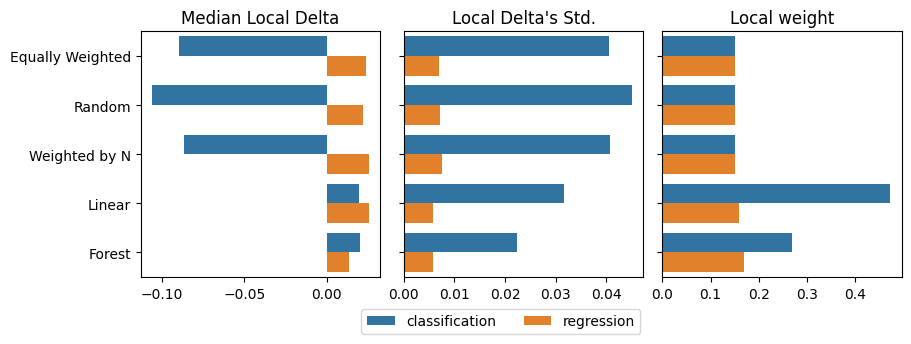

In [17]:
by_plots(
    df=res_table_val,
    groupby=['Metamodel Type','Task'],
    hue='Task',
    xs=['Median Local Delta','Local Delta\'s Std.','Local weight'],
    index_order=index_order,
    fname='tmp/model_experiments/no_reg_by_task.png'
)

### By $\alpha$

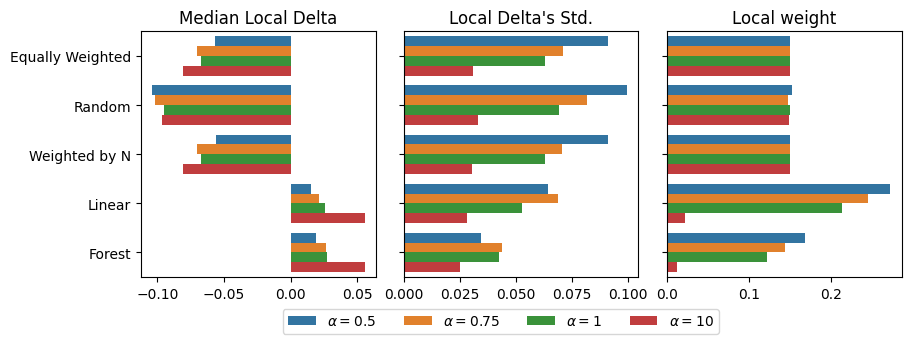

In [56]:
by_plots(
    df=res_table_val[res_table_val['P. Method']=='dirY'],
    groupby=['Metamodel Type','Param'],
    hue='Param',
    xs=['Median Local Delta','Local Delta\'s Std.','Local weight'],
    index_order=index_order,
    fname='tmp/model_experiments/no_reg_by_alpha.png'
)

### By a

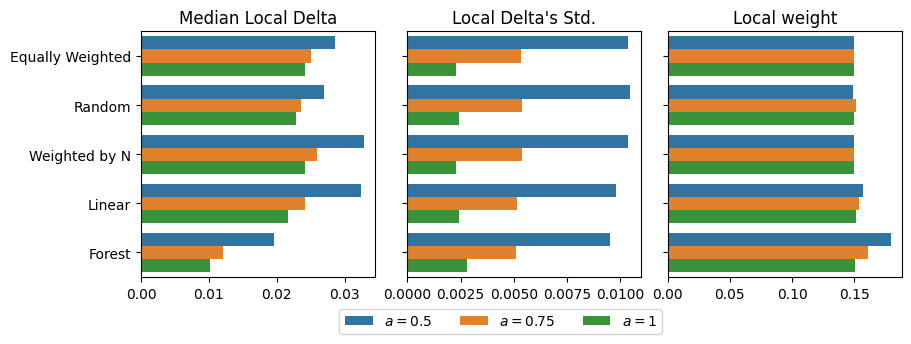

In [18]:
by_plots(
    df=res_table_val[(res_table_val['P. Method']=='powN') & (res_table_val['Task']=='regression')],
    groupby=['Metamodel Type','Param'],
    hue='Param',
    xs=['Median Local Delta','Local Delta\'s Std.','Local weight'],
    index_order=index_order,
    fname='tmp/model_experiments/no_reg_by_a_regression.png'
)

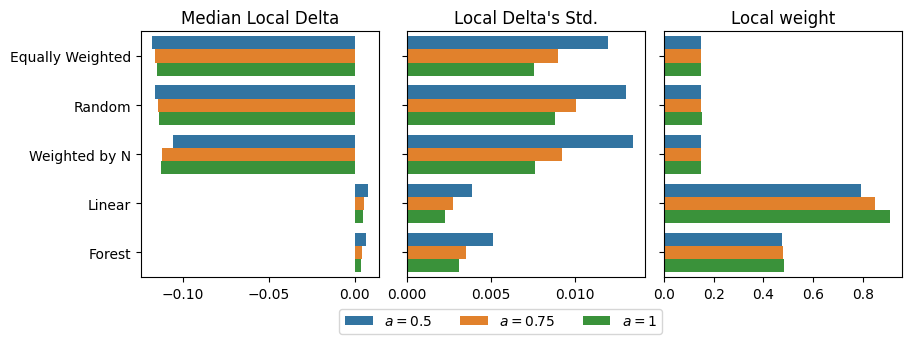

In [58]:
by_plots(
    df=res_table_val[(res_table_val['P. Method']=='powN') & (res_table_val['Task']=='classification')],
    groupby=['Metamodel Type','Param'],
    hue='Param',
    xs=['Median Local Delta','Local Delta\'s Std.','Local weight'],
    index_order=index_order,
    fname='tmp/model_experiments/no_reg_by_a_classification.png'
)

### Importance and Local Delta by N

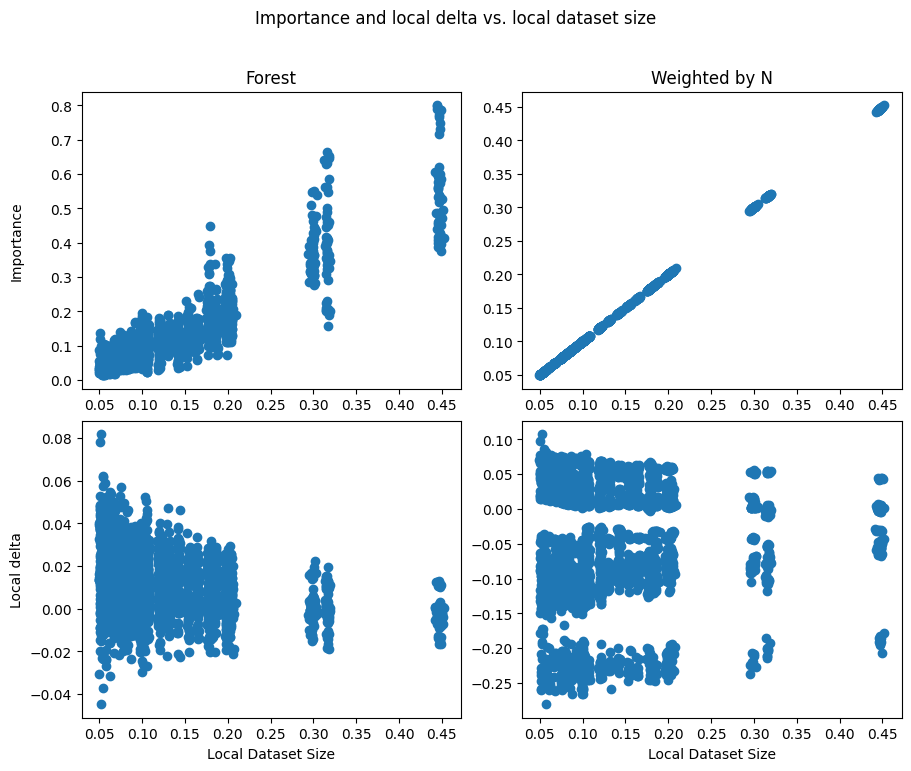

In [12]:
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, sharey=False,sharex=False,figsize=(9,7),layout='constrained')

for ax,island_type in zip([ax1,ax2],['Forest prop=1.0','By N']):

    x=[n for n,mean_y,imp,task,params,dt in imp_by_n_ymean[island_type] if 'a' in params and 'reg' in task]
    y=[imp for n,mean_y,imp,task,params,dt in imp_by_n_ymean[island_type] if 'a' in params and 'reg' in task]

    ax.scatter(x,y)
    if ax==ax1:
        ax.set_ylabel('Importance')
    
    if ax==ax1:
        ax.set_title('Forest')
    else:
        ax.set_title('Weighted by N')
        
    
for ax,island_type in zip([ax3,ax4],['Forest prop=1.0','By N']):

    x=[n for n,y_mean,delta,task,p_params,dt in deltas_by_n_ymean[island_type] if 'a' in p_params]
    y=[delta for n,y_mean,delta,task,p_params,dt in deltas_by_n_ymean[island_type] if 'a' in p_params]

    ax.scatter(x,y)
    
    if ax==ax3:
        ax.set_ylabel('Local delta')
    
    ax.set_xlabel('Local Dataset Size')
    
f.suptitle('Importance and local delta vs. local dataset size',y=1.08)   

f.align_labels()

f.savefig('tmp/model_experiments/no_reg_size_imp_gain.png',bbox_inches='tight')


## Contrast with data pooling experiments

In [386]:
# Get data experiments data - best models per partition and island
data_exp_data=pd.read_csv('tmp/data_experiments/natural_table.csv')
best_models_data={}

for _,(partition,island,best_model) in data_exp_data[['Partition','Island','Best Model']].iterrows():
    
    best_models=get_islands_from_str(best_model)
    if 'Local' in best_models:
        best_models=[island]
        
    best_models=set(best_models)
    if partition not in best_models_data:
        best_models_data[partition]={}
    
    best_models_data[partition][island]=best_models
    #print(partition,island,best_models)

In [393]:
out={}
# Weights of model experiments
for model_type in w:
    
    out[model_type]={'included':[],'not':[]}

    for partition,weights in w[model_type].items():
        if 'natural' in partition:
            for island,others_weights in weights.items():

                for i in best_models_data[partition][island]:
                    out[model_type]['included'].append(others_weights[str(i)])

                for i in others_weights:

                    if i not in best_models_data[partition][island]:
                        out[model_type]['not'].append(others_weights[i])


                from_data=best_models_data[partition][island]
                from_data={str(i) for i in from_data}
                from_model=sorted(others_weights,key=others_weights.get,reverse=True)[:len(from_data)]
                from_model=set([str(i) for i in from_model])


r=[]
for model_type,d in out.items():
    if 'Local' in model_type: continue
    r.append([model_type,np.array(d['included']).mean(),np.array(d['not']).mean()])


t=pd.DataFrame(
    r,
    columns=['Meta model type','Mean weight given to included','Mean weight given to not included']
)

t['Meta model type']=t['Meta model type'].replace({'By N':'Weighted by N','Forest prop=1.0':'Forest','Linear prop=1.0':'Linear'})

t.to_csv('tmp/model_experiments/contrast_with_data.csv')
t

,Meta model type,Mean weight given to included,Mean weight given to not included
0,Equally Weighted,0.114392,0.107829
1,Linear,0.208590,0.074310
2,Forest,0.189053,0.074365
3,Weighted by N,0.110175,0.110697
4,Random,0.113547,0.108556


## Compare train/val meta train and local/global eval

In [36]:
# Load the rest of the results

# Meta train: train | Eval: local
res,metrics=load_results('results/model_experiments_train/')
res_table_train,_,_,_,_=gen_table(
    res,
    'local_splits',
    'partitions/model_experiments/',
    'Local',
    metrics
)

res_table_train['Island Type']=res_table_train['Island Type'].replace({'By N':'Weighted by N'})

In [44]:
res_table_train['Train With']="train"

In [41]:
train_model_types=res_table_train['Island Type'].unique()

In [45]:
res_table_val_limited=res_table_val[res_table_val['Island Type'].str.contains('|'.join(train_model_types))]
res_table_val_limited['Train With']="val"

/var/folders/0h/vcn6t_g17tz26n1l1nk44v180000gn/T/ipykernel_86337/1929162545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_table_val_limited['Train With']="val"


In [51]:
res_table_train.shape

(4020, 21)

In [50]:
res_table_val_limited.shape

(4020, 21)

In [60]:
t=pd.concat([res_table_train,res_table_val_limited]).groupby(['Island Type','Train With'])[
    'Median Delta','Mean Delta','STD Delta','% Islands Improved','Zero weights','Local weight'
].mean()
t.to_csv('tmp/model_experiments/val_train_contrast.csv')
t

/var/folders/0h/vcn6t_g17tz26n1l1nk44v180000gn/T/ipykernel_86337/1310042571.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  t=pd.concat([res_table_train,res_table_val_limited]).groupby(['Island Type','Train With'])[


Median Delta  Mean Delta  STD Delta  \
Island Type      Train With                                        
Equally Weighted train          -0.055125   -0.062013   0.030477   
                 val            -0.055103   -0.062032   0.030409   
Forest           train          -0.005670   -0.005117   0.003839   
                 val             0.018300    0.017866   0.017426   
Random           train          -0.067992   -0.072503   0.032894   
                 val            -0.067336   -0.072879   0.033621   
Weighted by N    train          -0.052692   -0.059398   0.030770   
                 val            -0.052692   -0.059396   0.030752   

                             % Islands Improved  Zero weights  Local weight  
Island Type      Train With                                                  
Equally Weighted train                 0.369737      0.000000      0.150276  
                 val                   0.370162      0.000000      0.150276  
Forest           train                 0.388252      0.000004      0.744874  
                 val                   0.758255      0.301648      0.239225  
Random           train                 0.357703      0.000000      0.149336  
                 val                   0.357264      0.000000      0.150148  
Weighted by N    train                 0.372051      0.000000      0.150276  
                 val                   0.371736      0.000000      0.150276

In [42]:
# Add as dataframe
pd.DataFrame([    
    res_table_val_limited[
        ['Median Delta','Mean Delta','STD Delta','% Islands Improved','Zero weights','Local weight']
    ].mean(),
    res_table_train[
        ['Median Delta','Mean Delta','STD Delta','% Islands Improved','Zero weights','Local weight']
    ].mean(),
],index=['Validation Local Test','Train Local Test'])

,Median Delta,Mean Delta,STD Delta,% Islands Improved,Zero weights,Local weight
Validation Local Test,-0.039208,-0.044110,0.028052,0.464354,7.541194e-02,0.172481
Train Local Test,-0.045370,-0.049758,0.024495,0.371936,9.950249e-07,0.298691


## Multiple local model types

In [14]:
# Load the multiple models results
res,metrics=load_results('results/multiple_models/')
res_table_mult_models,ws,importances,_,_,detailed_r=gen_table(
    res,
    'local_splits',
    'partitions/model_experiments/',
    'Local',
    metrics,
    detailed=True
)
res_table_mult_models['Island Type']=res_table_mult_models['Island Type'].replace({'By N':'Weighted by N','Forest prop=1.0':'Forest','Linear prop=1.0':'Linear'})

In [521]:
# Get the island importances 
d={}
for partition, imps in importances['Forest'].items():
    for island, importance in imps.items():
        if island not in d:
            d[island]=[]
        d[island].append(importance)

d={k:np.array(v).mean() for k,v in d.items()}

# Group by model types
assignments={
    '0':'Forest',
    '1':'Forest',
    '2':'Linear',
    '3':'Linear',
    '4':'SGD',
    '5':'SGD',
    '6':'KNeighbors',
    '7':'KNeighbors',
    '8':'GradientBoosting',
    '9':'GradientBoosting'
}
by_model_type={}
for k,v in d.items():
    model=assignments[k]
    if model not in by_model_type:
        by_model_type[model]=[]
    by_model_type[model].append(v)

by_model_type={k:np.mean(v) for k,v in by_model_type.items()}
by_model_type=pd.Series(by_model_type)

In [548]:
# Load scores by models on entire dataset
temp=pd.DataFrame(utils.loadPickeObj('tmp/model_experiments','model_scores_whole_dataset.pkl'))
temp=temp[temp[3]>0]
temp[2]=temp[2].str.split('.').str[-1].str.split('\'').str[0].replace(
    {'RandomForest(.+)':'Forest','(.+)Regression':'Linear','SGD(.+)':'SGD','KNeighbors(.+)':'KNeighbors','GradientBoosting(.+)':'GradientBoosting'},
    regex=True
)
t=temp.groupby(2,as_index=True).mean()

# Merge
t[4]=by_model_type
t=t.sort_values(3)
t=t.rename(columns={3:'Mean CV score on whole dataset',4:'Mean importance given'})

t.to_csv('tmp/model_experiments/mult_models_imp_score_corr.csv')
t

/var/folders/0h/vcn6t_g17tz26n1l1nk44v180000gn/T/ipykernel_28556/1710866347.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t=temp.groupby(2,as_index=True).mean()


,Mean CV score on whole dataset,Mean importance given
2,,
SGD,0.654976,0.043683
KNeighbors,0.703917,0.036374
Linear,0.705840,0.062035
GradientBoosting,0.828428,0.152453
Forest,0.862161,0.166993


In [538]:
# And their correlation
t.corr()

,3,4
3,1.000000,0.970499
4,0.970499,1.000000


In [552]:
# FIG X.X
t=res_table_mult_models.groupby(['Task','Island Type'])[
    ['Median Delta','Mean Delta','STD Delta','% Islands Improved']
].mean()

t.to_csv('tmp/model_experiments/mult_models_summary.csv')
t

Median Delta  Mean Delta  STD Delta  \
Task           Island Type                                             
classification Equally Weighted      0.005983   -0.020032   0.146848   
               Forest                0.137335    0.138831   0.126478   
               Random               -0.020643   -0.050795   0.157905   
               Weighted by N         0.034663    0.012682   0.141974   
regression     Equally Weighted      0.049841    0.065445   0.110681   
               Forest                0.074884    0.091428   0.110529   
               Random                0.042945    0.061270   0.111838   
               Weighted by N         0.058475    0.074434   0.110671   

                                 % Islands Improved  
Task           Island Type                           
classification Equally Weighted            0.505000  
               Forest                      0.839091  
               Random                      0.470000  
               Weighted by N               0.545000  
regression     Equally Weighted            0.703030  
               Forest                      0.737879  
               Random                      0.686364  
               Weighted by N               0.736364

## Regularization

In [466]:
res,metrics=load_results('results/model_experiments/')

res_table_val_all,w,importances,deltas_by_n_ymean,imp_by_n_ymean=gen_table(
    res,
    'local_splits',
    'partitions/model_experiments/',
    'Local',
    metrics
)

In [482]:
t=res_table_val_all[res_table_val_all['Island Type'].str.contains('C=')].groupby(['Island Type'])[
    ['Median Delta','STD Delta','% Islands Improved','Zero weights']
].mean()

t.to_csv('tmp/model_experiments/reg_effect.csv')
t

,Median Delta,STD Delta,% Islands Improved,Zero weights
Island Type,,,,
Linear C=0.00001,-0.182871,0.062045,0.524229,0.788956
Linear C=0.001,-0.172997,0.066967,0.524183,0.749567
Linear C=0.1,0.002974,0.040216,0.660639,0.649346
Linear C=1,0.022391,0.019388,0.806917,0.510743
Linear C=10,0.022833,0.016056,0.787636,0.358411
Linear C=100,0.022523,0.016127,0.776889,0.311332
